# Tensorflow - Cat State Detect - Project

![Ảnh minh họa mèo](https://i.ytimg.com/vi/HIdLXBn-Py0/maxresdefault.jpg)

# Xây dựng mô hình

## 1. Import thư viện cần thiết

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import os
import IPython.display as ipd
import librosa
import librosa.display

import tensorflow as tf
import tensorflow_io as tfio

import warnings
warnings.filterwarnings("ignore")

Kiểm tra xem tensorflow đang sử dụng GPU (khuyến khích) hay CPU

In [2]:
print(tf.config.list_physical_devices('GPU'))
tf.test.is_gpu_available()

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]
Instructions for updating:
Use `tf.config.list_physical_devices('GPU')` instead.


True

## 2. Phân tích khai phá dữ liệu (EDA)

- Kiểm tra sơ đồ thư mục

In [3]:
DATA_PATH = 'dataset/dataset/'

In [4]:
# Trạng thái mèo 'F' : 'Waiting For Food', 'I' : 'Isolated in unfamiliar Environment', 'B' : 'Brushing'
wav_dict = {'F' : [], 'I' : [], 'B' : []}

for path in os.listdir(DATA_PATH):
    list_split = path.split('_')
    if list_split[0] in wav_dict.keys():
        wav_dict[list_split[0]].append(path)

In [5]:
print(f"Trong thư mục {DATA_PATH} có: {len(os.listdir(DATA_PATH))} files")
for key in wav_dict:
    print(f"--> Lớp {key} có {len(wav_dict[key])} files")

Trong thư mục dataset/dataset/ có: 440 files
--> Lớp F có 92 files
--> Lớp I có 221 files
--> Lớp B có 127 files


- Tạo Dataframe

In [6]:
state = []
state_sample = {'F' : 'Waiting For Food', 'I' : 'Isolated in unfamiliar Environment', 'B' : 'Brushing'}
cat_id = []
cat_type = []
cat_type_sample = {'MC' : 'Maine Coon', 'EU': 'European Shorthair'}
sex = []
owner_id = []  
recording_session = [] 
meow_counter = []
audio_path = []

for path in os.listdir(DATA_PATH):
    list_split = path.split('_')
    if list_split[0] in state_sample.keys():
        state.append(state_sample[list_split[0]])
    else:
        state.append('Unknown')
    cat_id.append(list_split[1])
    if list_split[2] in cat_type_sample.keys():
        cat_type.append(cat_type_sample[list_split[2]])
    else:
        cat_type.append('Unknown')
    sex.append(list_split[3])
    owner_id.append(list_split[4])
    recording_session.append(int(list_split[5][0]))
    meow_counter.append(int(list_split[5][1:3]))
    audio_path.append(path)
    
    

In [7]:
# Tạo DataFrame từ các danh sách đã thu thập dữ liệu
data = {
    'Cat_ID': cat_id,
    'State': state,
    'Cat_Type': cat_type,
    'Sex': sex,
    'Owner_ID': owner_id,
    'Recording_Session': recording_session,
    'Meow_Counter': meow_counter,
    'Audio_Path': audio_path
}

df = pd.DataFrame(data)
df.head(5)

,Cat_ID,State,Cat_Type,Sex,Owner_ID,Recording_Session,Meow_Counter,Audio_Path
0,ANI01,Brushing,Maine Coon,FN,SIM01,1,1,B_ANI01_MC_FN_SIM01_101.wav
1,ANI01,Brushing,Maine Coon,FN,SIM01,1,2,B_ANI01_MC_FN_SIM01_102.wav
2,ANI01,Brushing,Maine Coon,FN,SIM01,1,3,B_ANI01_MC_FN_SIM01_103.wav
3,ANI01,Brushing,Maine Coon,FN,SIM01,3,1,B_ANI01_MC_FN_SIM01_301.wav
4,ANI01,Brushing,Maine Coon,FN,SIM01,3,2,B_ANI01_MC_FN_SIM01_302.wav


In [8]:
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 440 entries, 0 to 439
Data columns (total 8 columns):
 #   Column             Non-Null Count  Dtype 
---  ------             --------------  ----- 
 0   Cat_ID             440 non-null    object
 1   State              440 non-null    object
 2   Cat_Type           440 non-null    object
 3   Sex                440 non-null    object
 4   Owner_ID           440 non-null    object
 5   Recording_Session  440 non-null    int64 
 6   Meow_Counter       440 non-null    int64 
 7   Audio_Path         440 non-null    object
dtypes: int64(2), object(6)
memory usage: 27.6+ KB


In [9]:
for col in df.columns:
    if col != "Audio_Path":
        print(df[col].unique())

['ANI01' 'BAC01' 'BRA01' 'BRI01' 'CAN01' 'DAK01' 'IND01' 'JJX01' 'MAG01'
 'MAT01' 'MIN01' 'NIG01' 'NUL01' 'REG01' 'SPI01' 'TIG01' 'WHO01' 'BLE01'
 'LEO01' 'MEG01' 'CLE01']
['Brushing' 'Waiting For Food' 'Isolated in unfamiliar Environment']
['Maine Coon' 'European Shorthair']
['FN' 'MN' 'FI' 'MI']
['SIM01' 'GIA01' 'ELI01' 'FED01' 'RIT01' 'BEN01' 'GIO01' 'NAI01' 'GIU01'
 'DEL01' 'SIM10' 'FER01']
[1 3 2 4]
[ 1  2  3  4  5  6  7  8  9 10 11 12 13 14 15 16 17 18 19 20 21]


In [10]:
print(f"Số dòng có giá trị null: \n{df.isnull().sum()}")
print(f"Số dòng duplicated: {df.duplicated().sum()}")

Số dòng có giá trị null: 
Cat_ID               0
State                0
Cat_Type             0
Sex                  0
Owner_ID             0
Recording_Session    0
Meow_Counter         0
Audio_Path           0
dtype: int64
Số dòng duplicated: 0


In [11]:
df.describe()

,Recording_Session,Meow_Counter
count,440.000000,440.000000
mean,1.902273,4.406818
std,0.875896,4.001759
min,1.000000,1.000000
25%,1.000000,2.000000
50%,2.000000,3.000000
75%,3.000000,5.250000
max,4.000000,21.000000


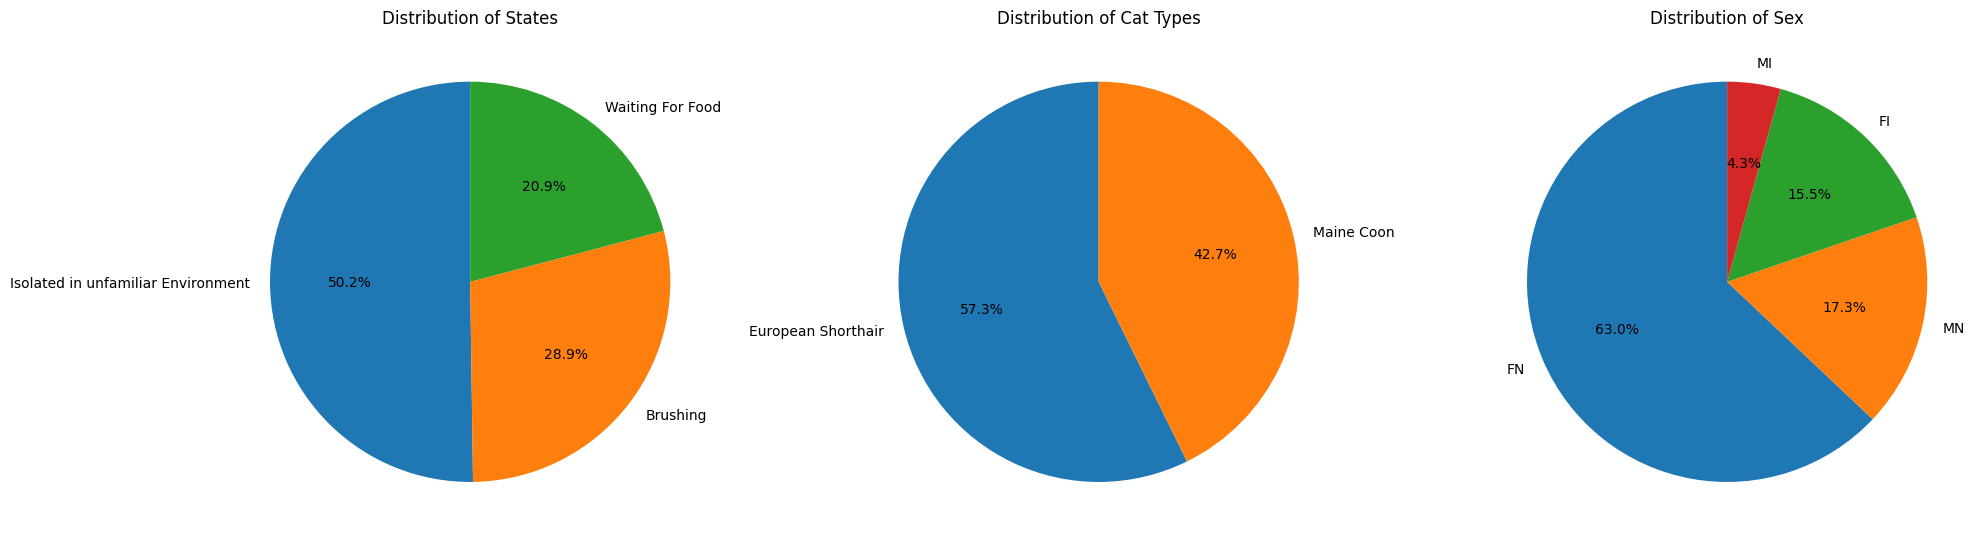

In [12]:
# Vẽ các biểu đồ tròn
fig, axs = plt.subplots(1, 3, figsize=(20, 10))
state_counts = df['State'].value_counts()
axs[0].pie(state_counts, labels=state_counts.index, autopct='%1.1f%%', startangle=90)
axs[0].set_title('Distribution of States')
cat_type_counts = df['Cat_Type'].value_counts()
axs[1].pie(cat_type_counts, labels=cat_type_counts.index, autopct='%1.1f%%', startangle=90)
axs[1].set_title('Distribution of Cat Types')
sex_counts = df['Sex'].value_counts()
axs[2].pie(sex_counts, labels=sex_counts.index, autopct='%1.1f%%', startangle=90)
axs[2].set_title('Distribution of Sex')

plt.tight_layout()
plt.show()

- Kiểm tra ngẫu nhiên file audio

In [13]:
random_rows = df.sample(n=12)
filepath = DATA_PATH + random_rows.iloc[0].Audio_Path
data , sample_rate = librosa.load(filepath)
librosa.load(filepath)
sample_rate

22050

In [14]:
ipd.Audio(filepath)

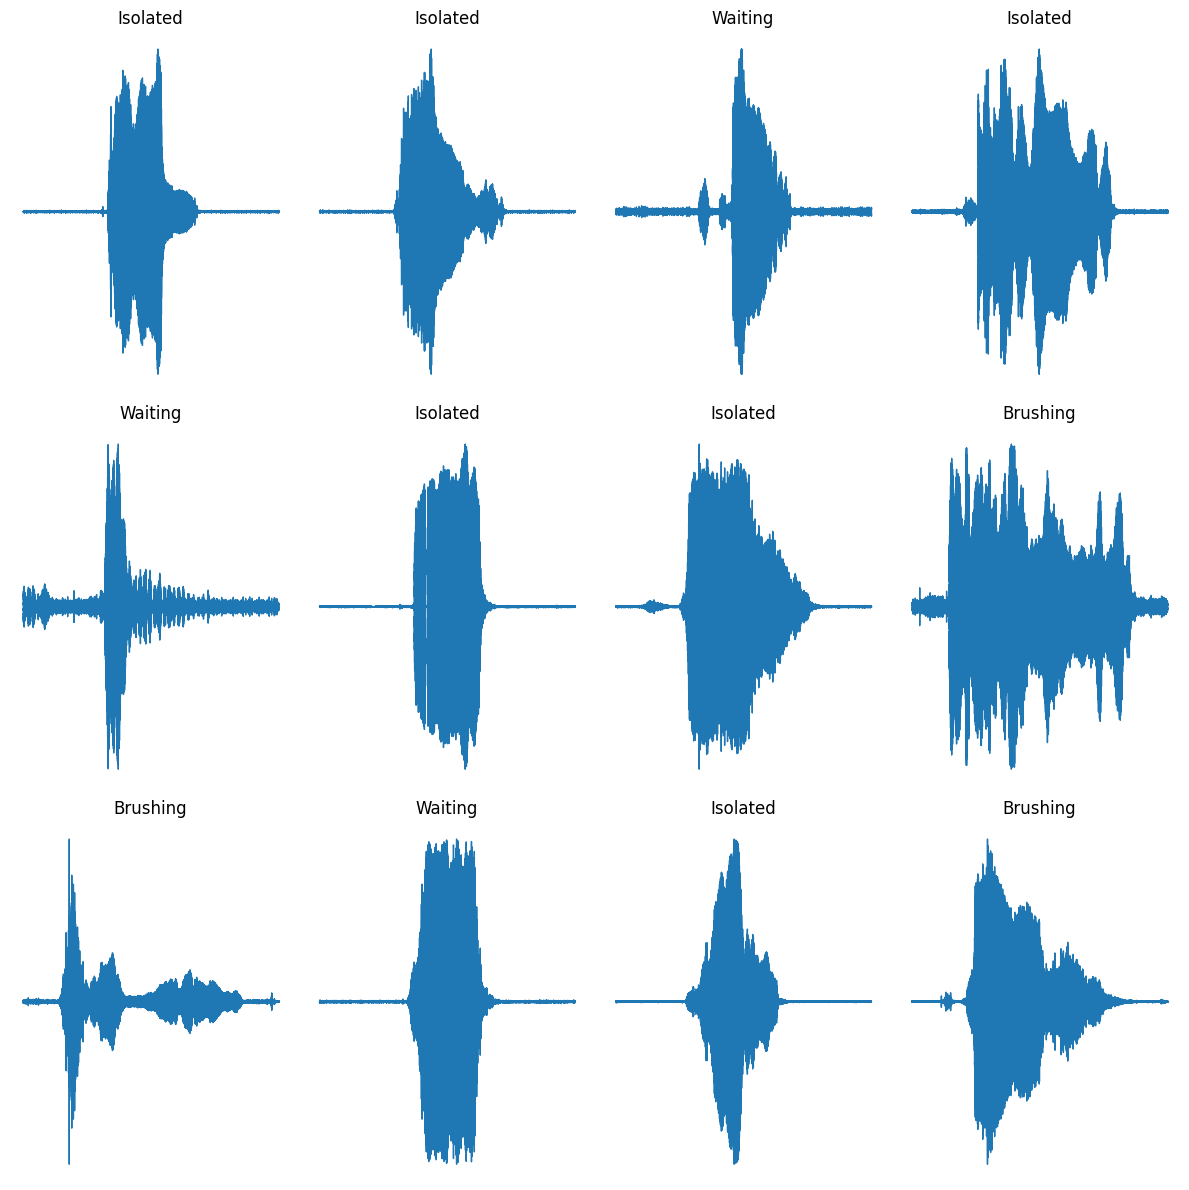

In [15]:
plt.figure(figsize=(12,12))
for i in range(12):
    random_row = random_rows.iloc[i]
    axs = plt.subplot(3,4,i+1)
    filepath = DATA_PATH + random_row.Audio_Path
    data , sample_rate = librosa.load(filepath)
    librosa.load(filepath)
    librosa.display.waveshow(data,ax=axs)
    plt.title(random_row.State.split(" ")[0])
    plt.axis("off")

plt.tight_layout()
plt.show()

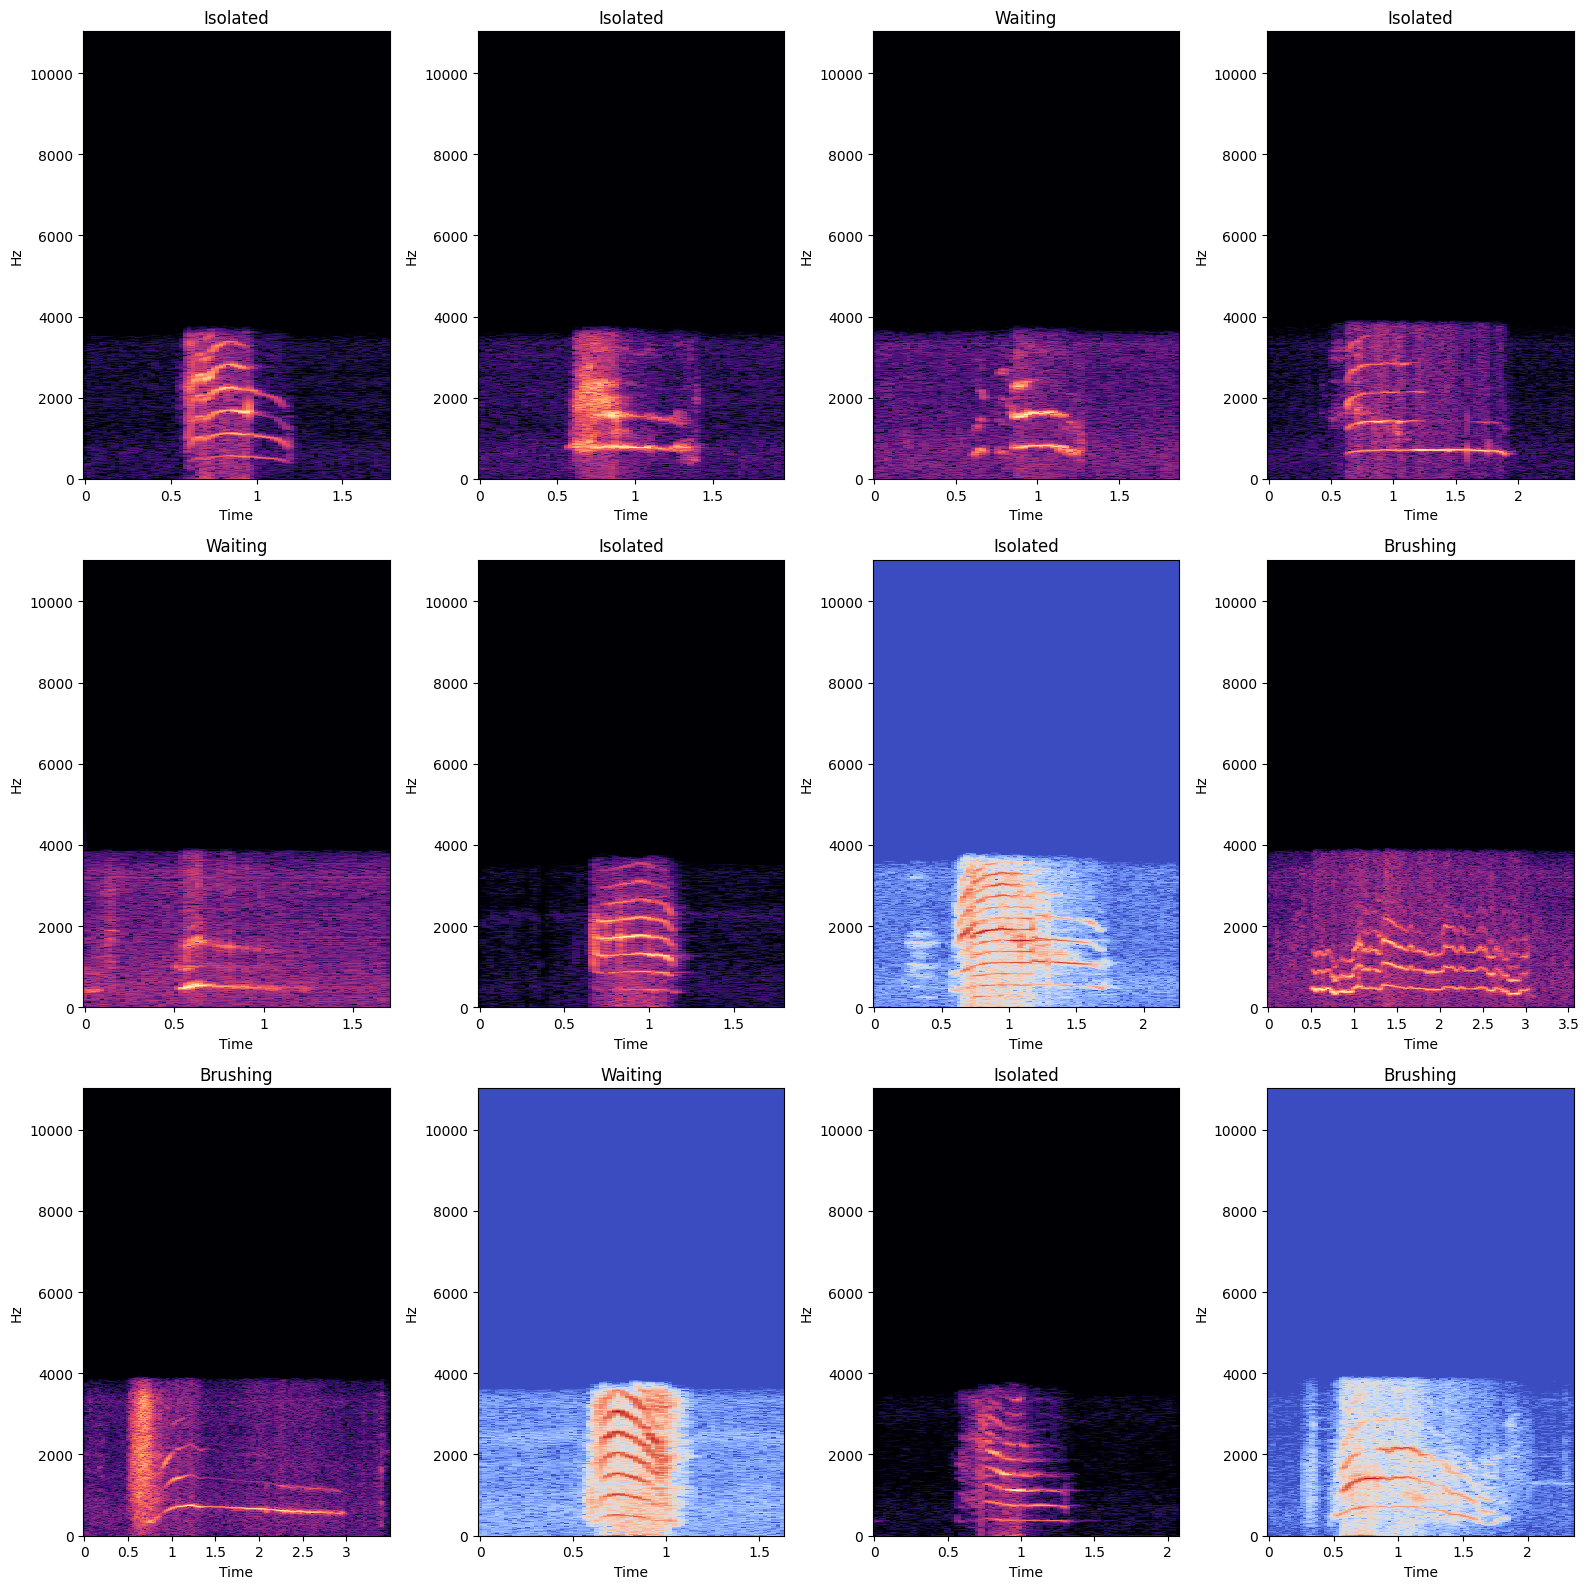

In [16]:
plt.figure(figsize=(16,16))
for i in range(12):
    random_row = random_rows.iloc[i]
    axs = plt.subplot(3,4,i+1)
    filepath = DATA_PATH + random_row.Audio_Path
    data , sample_rate = librosa.load(filepath)
    librosa.load(filepath)
    X = librosa.stft(data)
    Xdb = librosa.amplitude_to_db(abs(X))
    librosa.display.specshow(Xdb, sr=sample_rate, x_axis='time', y_axis='hz',ax=axs)
    plt.title(random_row.State.split(" ")[0])

plt.tight_layout()
plt.show()

## 3. Tạo Tensorflow Dataset và Tiền xử lý dữ liệu

### 3.1. Tạo ra Tensorflow Dataset

In [17]:
# Trạng thái mèo 'F' : 'Waiting For Food', 'I' : 'Isolated in unfamiliar Environment', 'B' : 'Brushing'
F_c = tf.data.Dataset.from_tensor_slices(wav_dict["F"])
I_c = tf.data.Dataset.from_tensor_slices(wav_dict["I"])
B_c = tf.data.Dataset.from_tensor_slices(wav_dict["B"])

### 3.2. Thêm label cho Dataset

In [18]:
F_label = tf.data.Dataset.from_tensor_slices(tf.zeros(len(F_c), dtype=tf.int32))
I_label = tf.data.Dataset.from_tensor_slices(tf.ones(len(I_c), dtype=tf.int32))
B_label = tf.data.Dataset.from_tensor_slices(tf.fill([len(B_c)],2))

In [19]:
F_class = tf.data.Dataset.zip((F_c,F_label))
I_class = tf.data.Dataset.zip((I_c,I_label))
B_class = tf.data.Dataset.zip((B_c,B_label))

In [20]:
dataset = F_class.concatenate(I_class).concatenate(B_class)

### 3.3. Tiền xử lý

- Ta thấy các file audio đa phần đã được xử lí sạch sẽ tuy nhiên ta vẫn cần tiền xử lý kĩ hơn:
> - Load file wav vào lại với setting sample_rate (16k), channel (mono) 

In [28]:
def load_wav(path):
    file = tf.io.read_file(path)
    wav, sample_rate = tf.audio.decode_wav(file, desired_channels=1)
    wav = tf.squeeze(wav, axis=-1)
    sample_rate = tf.cast(sample_rate, dtype=tf.int64)
    wav = tfio.audio.resample(wav, rate_in=sample_rate, rate_out=16000)
    return wav

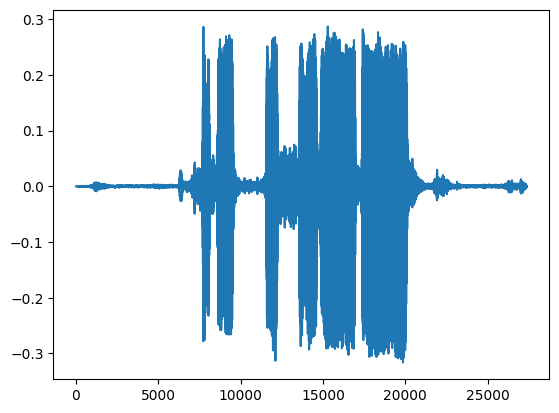

In [27]:
plt.plot(load_wav('dataset/dataset/B_ANI01_MC_FN_SIM01_101.wav'))
plt.show()

- Đưa về dạng Spectrogram (quang phổ)

In [29]:
def preprocess(path, label): 
    wav = load_wav(path)
    wav = wav[:48000]
    zero_padding = tf.zeros([48000] - tf.shape(wav), dtype=tf.float32)
    wav = tf.concat([zero_padding, wav],0)
    spectrogram = tf.signal.stft(wav, frame_length=320, frame_step=32)
    spectrogram = tf.abs(spectrogram)
    spectrogram = tf.expand_dims(spectrogram, axis=2)
    return spectrogram, label

- Ta sẽ dùng hàm ở trên để map data của chúng ta, sau đó làm một số thao tác sau:
> - Đưa data vào bộ nhớ cache để mô hình truy xuất nhanh hơn khi train
> - Trộn dữ liệu
> - Chia dữ liệu

In [31]:
dataset = dataset.map(preprocess)
dataset = dataset.cache()
dataset = dataset.shuffle(buffer_size=1000)
dataset = dataset.batch(16)
dataset = dataset.prefetch(8)

In [34]:
data_train = dataset.take(22)
data_test = dataset.skip(22).take(6)

In [50]:
data_train.as_numpy_iterator().next()

NotFoundError: {{function_node __wrapped__IteratorGetNext_output_types_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} NewRandomAccessFile failed to Create/Open: F_BAC01_MC_MN_SIM01_101.wav : The system cannot find the file specified.
; No such file or directory
	 [[{{node ReadFile}}]] [Op:IteratorGetNext]

## 4. Xây dựng mô hình

### 4.1. Setup các thông số mô hình

In [ ]:
CHANNELS = 3
EPOCH = 50
INPUT_SHAPE = (IMG_SIZE, IMG_SIZE, CHANNELS)
NUM_CLASSES = 4

In [41]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Conv2D, Dense, Flatten

model = Sequential()
model.add(Conv2D(16, (3,3), activation='relu', input_shape=(1491, 257,1)))
model.add(Conv2D(16, (3,3), activation='relu'))
model.add(Flatten())
model.add(Dense(1, activation='sigmoid'))

In [42]:
model.compile('Adam', loss='BinaryCrossentropy', metrics=[tf.keras.metrics.Recall(),tf.keras.metrics.Precision()])

In [43]:
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_2 (Conv2D)           (None, 1489, 255, 16)     160       
                                                                 
 conv2d_3 (Conv2D)           (None, 1487, 253, 16)     2320      
                                                                 
 flatten_1 (Flatten)         (None, 6019376)           0         
                                                                 
 dense_1 (Dense)             (None, 1)                 6019377   
                                                                 
Total params: 6,021,857
Trainable params: 6,021,857
Non-trainable params: 0
_________________________________________________________________


In [45]:
hist = model.fit(data_train, epochs=4, validation_data=data_test)

Epoch 1/4


NotFoundError: Graph execution error:

2 root error(s) found.
  (0) NOT_FOUND:  NewRandomAccessFile failed to Create/Open: F_BAC01_MC_MN_SIM01_101.wav : The system cannot find the file specified.
; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
	 [[IteratorGetNext/_7]]
  (1) NOT_FOUND:  NewRandomAccessFile failed to Create/Open: F_BAC01_MC_MN_SIM01_101.wav : The system cannot find the file specified.
; No such file or directory
	 [[{{node ReadFile}}]]
	 [[IteratorGetNext]]
0 successful operations.
0 derived errors ignored. [Op:__inference_train_function_1855]